In [104]:
import torch
from torch import nn
import torch.nn.functional as F
import math

In [105]:
class BaseFlowLayer(nn.Module):
    """
    """

    def __init__(self):
        super().__init__()

    def forward(self, *args):
        raise NotImplemented

    def backward(self, *args):
        raise NotImplemented


class UnconditionalBaseFlowLayer(BaseFlowLayer):
    """
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        raise NotImplemented

    def backward(self, z):
        raise NotImplemented


In [106]:
DEFAULT_MIN_BIN_WIDTH = 1e-3
DEFAULT_MIN_BIN_HEIGHT = 1e-3
DEFAULT_EPS = 1e-5
DEFAULT_QUADRATIC_THRESHOLD = 1e-3

In [196]:

def unconstrained_cubic_spline(inputs,
                               unnormalized_widths,
                               unnormalized_heights,
                               unnorm_derivatives_left,
                               unnorm_derivatives_right,
                               inverse=False,
                               tail_bound=1.,
                               tails='linear',
                               min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                               min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                               eps=DEFAULT_EPS,
                               quadratic_threshold=DEFAULT_QUADRATIC_THRESHOLD):
    inside_interval_mask = (inputs >= -tail_bound) & (inputs <= tail_bound)
    outside_interval_mask = ~inside_interval_mask

    outputs = torch.zeros_like(inputs)
    logabsdet = torch.zeros_like(inputs)

    if tails == 'linear':
        outputs[outside_interval_mask] = inputs[outside_interval_mask]
        logabsdet[outside_interval_mask] = 0
    else:
        raise RuntimeError('{} tails are not implemented.'.format(tails))
    x = inputs[inside_interval_mask]
    if x.shape[0] > 0:  # Support the case where all point are out of bound
        outputs[inside_interval_mask], logabsdet[inside_interval_mask] = cubic_spline(
            inputs=x,
            unnormalized_widths=unnormalized_widths[inside_interval_mask, :],
            unnormalized_heights=unnormalized_heights[inside_interval_mask, :],
            unnorm_derivatives_left=unnorm_derivatives_left[inside_interval_mask, :],
            unnorm_derivatives_right=unnorm_derivatives_right[inside_interval_mask, :],
            inverse=inverse,
            left=-tail_bound, right=tail_bound, bottom=-tail_bound, top=tail_bound,
            min_bin_width=min_bin_width,
            min_bin_height=min_bin_height,
            eps=eps,
            quadratic_threshold=quadratic_threshold
        )

    return outputs, logabsdet


In [197]:
import torch


# This code is base on code from https://github.com/bayesiains/nsf with some modifications


def searchsorted(bin_locations, inputs, eps=1e-6):
    bin_locations[..., -1] += eps
    return torch.sum(
        inputs[..., None] >= bin_locations,
        dim=-1
    ) - 1


class InputOutsideDomain(Exception):
    """Exception to be thrown when the input to a transform is not within its domain."""
    pass


def cbrt(x):
    """Cube root. Equivalent to torch.pow(x, 1/3), but numerically stable."""
    return torch.sign(x) * torch.exp(torch.log(torch.abs(x)) / 3.0)

In [198]:
def cubic_spline(inputs,
                 unnormalized_widths,
                 unnormalized_heights,
                 unnorm_derivatives_left,
                 unnorm_derivatives_right,
                 inverse=False,
                 left=0., right=1., bottom=0., top=1.,
                 min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                 min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                 eps=DEFAULT_EPS,
                 quadratic_threshold=DEFAULT_QUADRATIC_THRESHOLD):
    """
    References:
    > Blinn, J. F. (2007). How to solve a cubic equation, part 5: Back to numerics. IEEE Computer
    Graphics and Applications, 27(3):78–89.
    """
    if not inverse and (torch.min(inputs) < left or torch.max(inputs) > right):
        raise InputOutsideDomain()
    elif inverse and (torch.min(inputs) < bottom or torch.max(inputs) > top):
        raise InputOutsideDomain()

    num_bins = unnormalized_widths.shape[-1]

    if min_bin_width * num_bins > 1.0:
        raise ValueError('Minimal bin width too large for the number of bins')
    if min_bin_height * num_bins > 1.0:
        raise ValueError('Minimal bin height too large for the number of bins')

    if inverse:
        inputs = (inputs - bottom) / (top - bottom)
    else:
        inputs = (inputs - left) / (right - left)

    widths = F.softmax(unnormalized_widths, dim=-1)
    widths = min_bin_width + (1 - min_bin_width * num_bins) * widths

    cumwidths = torch.cumsum(widths, dim=-1)
    cumwidths[..., -1] = 1
    cumwidths = F.pad(cumwidths, pad=(1, 0), mode='constant', value=0.0)

    heights = F.softmax(unnormalized_heights, dim=-1)
    heights = min_bin_height + (1 - min_bin_height * num_bins) * heights

    cumheights = torch.cumsum(heights, dim=-1)
    cumheights[..., -1] = 1
    cumheights = F.pad(cumheights, pad=(1, 0), mode='constant', value=0.0)

    slopes = heights / widths
    min_something_1 = torch.min(torch.abs(slopes[..., :-1]),
                                torch.abs(slopes[..., 1:]))
    min_something_2 = (
            0.5 * (widths[..., 1:] * slopes[..., :-1] + widths[..., :-1] * slopes[..., 1:])
            / (widths[..., :-1] + widths[..., 1:])
    )
    min_something = torch.min(min_something_1, min_something_2)

    derivatives_left = torch.sigmoid(unnorm_derivatives_left) * 3 * slopes[..., 0][..., None]
    derivatives_right = torch.sigmoid(unnorm_derivatives_right) * 3 * slopes[..., -1][..., None]

    derivatives = min_something * (torch.sign(slopes[..., :-1]) + torch.sign(slopes[..., 1:]))
    derivatives = torch.cat([derivatives_left,
                             derivatives,
                             derivatives_right], dim=-1)

    a = (derivatives[..., :-1] + derivatives[..., 1:] - 2 * slopes) / widths.pow(2)
    b = (3 * slopes - 2 * derivatives[..., :-1] - derivatives[..., 1:]) / widths
    c = derivatives[..., :-1]
    d = cumheights[..., :-1]

    if inverse:
        bin_idx = searchsorted(cumheights, inputs)[..., None]
    else:
        bin_idx = searchsorted(cumwidths, inputs)[..., None]

    inputs_a = a.gather(-1, bin_idx)[..., 0]
    inputs_b = b.gather(-1, bin_idx)[..., 0]
    inputs_c = c.gather(-1, bin_idx)[..., 0]
    inputs_d = d.gather(-1, bin_idx)[..., 0]

    input_left_cumwidths = cumwidths.gather(-1, bin_idx)[..., 0]
    input_right_cumwidths = cumwidths.gather(-1, bin_idx + 1)[..., 0]

    if inverse:
        # Modified coefficients for solving the cubic.
        inputs_b_ = (inputs_b / inputs_a) / 3.
        inputs_c_ = (inputs_c / inputs_a) / 3.
        inputs_d_ = (inputs_d - inputs) / inputs_a

        delta_1 = -inputs_b_.pow(2) + inputs_c_
        delta_2 = -inputs_c_ * inputs_b_ + inputs_d_
        delta_3 = inputs_b_ * inputs_d_ - inputs_c_.pow(2)

        discriminant = 4. * delta_1 * delta_3 - delta_2.pow(2)

        depressed_1 = -2. * inputs_b_ * delta_1 + delta_2
        depressed_2 = delta_1

        three_roots_mask = discriminant >= 0  # Discriminant == 0 might be a problem in practice.
        one_root_mask = discriminant < 0

        outputs = torch.zeros_like(inputs)

        # Deal with one root cases.

        p = cbrt((-depressed_1[one_root_mask] + torch.sqrt(-discriminant[one_root_mask])) / 2.)
        q = cbrt((-depressed_1[one_root_mask] - torch.sqrt(-discriminant[one_root_mask])) / 2.)

        outputs[one_root_mask] = ((p + q)
                                  - inputs_b_[one_root_mask]
                                  + input_left_cumwidths[one_root_mask])

        # Deal with three root cases.

        theta = torch.atan2(torch.sqrt(discriminant[three_roots_mask]), -depressed_1[three_roots_mask])
        theta /= 3.

        cubic_root_1 = torch.cos(theta)
        cubic_root_2 = torch.sin(theta)

        root_1 = cubic_root_1
        root_2 = -0.5 * cubic_root_1 - 0.5 * math.sqrt(3) * cubic_root_2
        root_3 = -0.5 * cubic_root_1 + 0.5 * math.sqrt(3) * cubic_root_2

        root_scale = 2 * torch.sqrt(-depressed_2[three_roots_mask])
        root_shift = (-inputs_b_[three_roots_mask] + input_left_cumwidths[three_roots_mask])

        root_1 = root_1 * root_scale + root_shift
        root_2 = root_2 * root_scale + root_shift
        root_3 = root_3 * root_scale + root_shift

        root1_mask = ((input_left_cumwidths[three_roots_mask] - eps) < root_1).float()
        root1_mask *= (root_1 < (input_right_cumwidths[three_roots_mask] + eps)).float()

        root2_mask = ((input_left_cumwidths[three_roots_mask] - eps) < root_2).float()
        root2_mask *= (root_2 < (input_right_cumwidths[three_roots_mask] + eps)).float()

        root3_mask = ((input_left_cumwidths[three_roots_mask] - eps) < root_3).float()
        root3_mask *= (root_3 < (input_right_cumwidths[three_roots_mask] + eps)).float()

        roots = torch.stack([root_1, root_2, root_3], dim=-1)
        masks = torch.stack([root1_mask, root2_mask, root3_mask], dim=-1)
        mask_index = torch.argsort(masks, dim=-1, descending=True)[..., 0][..., None]
        outputs[three_roots_mask] = torch.gather(roots, dim=-1, index=mask_index).view(-1)

        # Deal with a -> 0 (almost quadratic) cases.

        quadratic_mask = inputs_a.abs() < quadratic_threshold
        a = inputs_b[quadratic_mask]
        b = inputs_c[quadratic_mask]
        c = (inputs_d[quadratic_mask] - inputs[quadratic_mask])
        alpha = (-b + torch.sqrt(b.pow(2) - 4 * a * c)) / (2 * a)
        outputs[quadratic_mask] = alpha + input_left_cumwidths[quadratic_mask]

        shifted_outputs = (outputs - input_left_cumwidths)
        logabsdet = -torch.log((3 * inputs_a * shifted_outputs.pow(2) +
                                2 * inputs_b * shifted_outputs +
                                inputs_c))
    else:
        shifted_inputs = (inputs - input_left_cumwidths)
        outputs = (inputs_a * shifted_inputs.pow(3) +
                   inputs_b * shifted_inputs.pow(2) +
                   inputs_c * shifted_inputs +
                   inputs_d)

        logabsdet = torch.log((3 * inputs_a * shifted_inputs.pow(2) +
                               2 * inputs_b * shifted_inputs +
                               inputs_c))

    if inverse:
        outputs = outputs * (right - left) + left
        logabsdet = logabsdet - math.log(top - bottom) + math.log(right - left)
    else:
        outputs = outputs * (top - bottom) + bottom
        logabsdet = logabsdet + math.log(top - bottom) - math.log(right - left)

    return outputs, logabsdet

In [199]:
def generate_mlp_class(n_layer=4, non_linear_function=nn.LeakyReLU, bias=True, output_nl=None):
    class MLPC(nn.Module):
        """ a simple n-layer MLP """

        def __init__(self, x_shape, nout, n_hidden):
            nin = x_shape[0] // 2
            super().__init__()
            if n_layer == 1:  # The case of singe layer
                layer_list = [nn.Linear(nin, nout, bias=bias)]
            else:
                layer_list = [nn.Linear(nin, n_hidden), non_linear_function()]
                for i in range(max(n_layer - 2, 0)):
                    layer_list.append(nn.Linear(n_hidden, n_hidden))
                    # torch.nn.init.xavier_normal_(layer_list[-1].weight)
                    layer_list.append(non_linear_function())
                layer_list.append(nn.Linear(n_hidden, nout, bias=bias))
                # torch.nn.init.xavier_normal_(layer_list[-1].weight)
            if output_nl is not None:
                layer_list.append(output_nl())
            self.net = nn.Sequential(*layer_list)

        def forward(self, x):
            return self.net(x)

    return MLPC


In [273]:
M = 2

class CSF_CL(UnconditionalBaseFlowLayer):
    """ Cubic Spline flow, coupling layer, [Durkan et al. 2019] """

    def __init__(self, dim, K=5, B=3, hidden_dim=8, base_network=generate_mlp_class()):
        super().__init__()
        self.dim = dim
        self.K = K
        self.B = B

        self.d = (M * K + 2) * dim // 2
        self.f1 = base_network([dim], (M * K + 2) * dim // 2, hidden_dim)
        self.f2 = base_network([dim], (M * K + 2) * dim // 2, hidden_dim)

    def split_param(self, in_param):
        out = in_param.reshape(-1, max(1, self.dim // 2), self.d)
        DL = out[:, :, -1].unsqueeze(dim=-1)
        DH = out[:, :, -2].unsqueeze(dim=-1)
        print(out.shape, self.K, 'here')
        print(out[:, :, :-2].shape)
        W, H = torch.split(out[:, :, :-2], self.K, dim=2)
        W, H = torch.softmax(W, dim=2), torch.softmax(H, dim=2)
        W, H = 2 * self.B * W, 2 * self.B * H
        return W, H, DL, DH

    def forward(self, x):
        log_det = torch.zeros(x.shape[0], device=x.device)
        lower, upper = x[:, :self.dim // 2], x[:, self.dim // 2:]
        out = self.f1(lower)
        print(out.shape)
        W, H, D_L, D_H = self.split_param(out)
        
        print(W.shape, H.shape, D_L.shape, D_H.shape)
        upper, ld = unconstrained_cubic_spline(upper, W, H, D_L,D_H, inverse=False, tail_bound=self.B)
        log_det += torch.sum(ld, dim=1)

        out = self.f2(upper)
        W, H, D_L, D_H = self.split_param(out)
        lower, ld = unconstrained_cubic_spline(lower, W, H, D_L, D_H, inverse=False, tail_bound=self.B)
        log_det += torch.sum(ld, dim=1)

        return torch.cat([lower, upper], dim=1), log_det

    def backward(self, z):
        log_det = torch.zeros(z.shape[0], device=z.device)
        lower, upper = z[:, :self.dim // 2], z[:, self.dim // 2:]
        out = self.f2(upper)
        W, H, DL, DH = self.split_param(out)
        lower, ld = unconstrained_cubic_spline(lower, W, H, DL, DH, inverse=True, tail_bound=self.B)
        log_det += torch.sum(ld, dim=1)
        out = self.f1(lower)
        W, H, DL, DH = self.split_param(out)
        upper, ld = unconstrained_cubic_spline(upper, W, H, DL, DH, inverse=True, tail_bound=self.B)
        log_det += torch.sum(ld, dim=1)
        return torch.cat([lower, upper], dim=1), log_det

In [274]:
y = torch.randn(4, 1, 4)

In [275]:
y[:, :, :-2].shape

torch.Size([4, 1, 2])

In [276]:
W, H = torch.split(y[:, :, :-2], 1, dim=-1)

In [277]:
d = 2

In [278]:
model = CSF_CL(d, K=5)

In [279]:
model(torch.randn(4, d))

torch.Size([4, 12])
torch.Size([4, 1, 12]) 5 here
torch.Size([4, 1, 10])
torch.Size([4, 1, 5]) torch.Size([4, 1, 5]) torch.Size([4, 1, 1]) torch.Size([4, 1, 1])
torch.Size([4, 1, 12]) 5 here
torch.Size([4, 1, 10])


(tensor([[ 0.9586,  0.2252],
         [-0.4069, -0.9949],
         [ 0.5790, -0.8923],
         [-0.3794, -0.7485]], grad_fn=<CatBackward0>),
 tensor([-0.7287, -0.0343, -0.4559, -0.1455], grad_fn=<AddBackward0>))

In [115]:
input_dim = 1
split_dim = None
dim=-1

In [116]:
if not isinstance(input_dim, int):
    if len(input_dim) != -dim:
        raise ValueError(
            "event shape {} must have same length as event_dim {}".format(
                input_dim, -dim
            )
        )
    event_shape = input_dim
    extra_dims = reduce(operator.mul, event_shape[(dim + 1) :], 1)
else:
    event_shape = [input_dim]
    extra_dims = 1
event_shape = list(event_shape)

if split_dim is None:
    split_dim = event_shape[dim] // 2
if hidden_dims is None:
    hidden_dims = [10 * event_shape[dim] * extra_dims]


NameError: name 'hidden_dims' is not defined

In [36]:
split_dim

0

In [53]:
import torch

from pyro.nn import DenseNN

from pyro.distributions import constraints
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.distributions.transforms.spline import ConditionalSpline, Spline


class SplineCoupling(TransformModule):
    r"""
    An implementation of the coupling layer with rational spline bijections of
    linear and quadratic order (Durkan et al., 2019; Dolatabadi et al., 2020).
    Rational splines are functions that are comprised of segments that are the ratio
    of two polynomials (see :class:`~pyro.distributions.transforms.Spline`).

    The spline coupling layer uses the transformation,

        :math:`\mathbf{y}_{1:d} = g_\theta(\mathbf{x}_{1:d})`
        :math:`\mathbf{y}_{(d+1):D} = h_\phi(\mathbf{x}_{(d+1):D};\mathbf{x}_{1:d})`

    where :math:`\mathbf{x}` are the inputs, :math:`\mathbf{y}` are the outputs,
    e.g. :math:`\mathbf{x}_{1:d}` represents the first :math:`d` elements of the
    inputs, :math:`g_\theta` is either the identity function or an elementwise
    rational monotonic spline with parameters :math:`\theta`, and :math:`h_\phi` is
    a conditional elementwise spline spline, conditioning on the first :math:`d`
    elements.

    Example usage:

    >>> from pyro.nn import DenseNN
    >>> input_dim = 10
    >>> split_dim = 6
    >>> count_bins = 8
    >>> base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
    >>> param_dims = [(input_dim - split_dim) * count_bins,
    ... (input_dim - split_dim) * count_bins,
    ... (input_dim - split_dim) * (count_bins - 1),
    ... (input_dim - split_dim) * count_bins]
    >>> hypernet = DenseNN(split_dim, [10*input_dim], param_dims)
    >>> transform = SplineCoupling(input_dim, split_dim, hypernet)
    >>> pyro.module("my_transform", transform)  # doctest: +SKIP
    >>> flow_dist = dist.TransformedDistribution(base_dist, [transform])
    >>> flow_dist.sample()  # doctest: +SKIP

    :param input_dim: Dimension of the input vector. Despite operating element-wise,
        this is required so we know how many parameters to store.
    :type input_dim: int
    :param split_dim: Zero-indexed dimension :math:`d` upon which to perform input/
        output split for transformation.
    :param hypernet: a neural network whose forward call returns a tuple of spline
        parameters (see :class:`~pyro.distributions.transforms.ConditionalSpline`).
    :type hypernet: callable
    :param count_bins: The number of segments comprising the spline.
    :type count_bins: int
    :param bound: The quantity :math:`K` determining the bounding box,
        :math:`[-K,K]\times[-K,K]`, of the spline.
    :type bound: float
    :param order: One of ['linear', 'quadratic'] specifying the order of the spline.
    :type order: string

    References:

    Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios. Neural
    Spline Flows. NeurIPS 2019.

    Hadi M. Dolatabadi, Sarah Erfani, Christopher Leckie. Invertible Generative
    Modeling using Linear Rational Splines. AISTATS 2020.

    """

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(
        self,
        input_dim,
        split_dim,
        hypernet,
        count_bins=8,
        bound=3.0,
        order="linear",
        identity=False,
    ):
        super(SplineCoupling, self).__init__(cache_size=1)

        # One part of the input is (optionally) put through an element-wise spline and the other part through a
        # conditional one that inputs the first part.
        self.lower_spline = Spline(split_dim, count_bins, bound, order)
        self.upper_spline = ConditionalSpline(
            hypernet, input_dim - split_dim, count_bins, bound, order
        )
        self.split_dim = split_dim
        self.identity = identity

    def _call(self, x):
        """
        :param x: the input into the bijection
        :type x: torch.Tensor

        Invokes the bijection x=>y; in the prototypical context of a
        :class:`~pyro.distributions.TransformedDistribution` `x` is a sample from
        the base distribution (or the output of a previous transform)
        """
        x1, x2 = x[..., : self.split_dim], x[..., self.split_dim :]
        
        print(x1.shape, x2.shape)
        if not self.identity:
            y1 = self.lower_spline(x1)
            log_detK = self.lower_spline._cache_log_detJ
        else:
            y1 = x1

        upper_spline = self.upper_spline.condition(x1)
        y2 = upper_spline(x2)
        log_detJ = upper_spline._cache_log_detJ

        if not self.identity:
            log_detJ = torch.cat([log_detJ, log_detK], dim=-1)
        self._cache_log_detJ = log_detJ

        return torch.cat([y1, y2], dim=-1)

    def _inverse(self, y):
        """
        :param y: the output of the bijection
        :type y: torch.Tensor

        Inverts y => x. Uses a previously cached inverse if available,
        otherwise performs the inversion afresh.
        """
        y1, y2 = y[..., : self.split_dim], y[..., self.split_dim :]

        if not self.identity:
            x1 = self.lower_spline._inv_call(y1)
            log_detK = self.lower_spline._cache_log_detJ
        else:
            x1 = y1

        upper_spline = self.upper_spline.condition(x1)
        x2 = upper_spline._inv_call(y2)
        log_detJ = upper_spline._cache_log_detJ

        if not self.identity:
            log_detJ = torch.cat([log_detJ, log_detK], dim=-1)
        self._cache_log_detJ = log_detJ

        return torch.cat([x1, x2], dim=-1)

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the elementwise determinant of the log jacobian
        """
        x_old, y_old = self._cached_x_y
        if x is not x_old or y is not y_old:
            # This call to the parent class Transform will update the cache
            # as well as calling self._call and recalculating y and log_detJ
            self(x)

        return self._cache_log_detJ.sum(-1)



def spline_coupling(
    input_dim, split_dim=None, hidden_dims=None, count_bins=8, bound=3.0
):
    """
    A helper function to create a
    :class:`~pyro.distributions.transforms.SplineCoupling` object for consistency
    with other helpers.

    :param input_dim: Dimension of input variable
    :type input_dim: int

    """

    if split_dim is None:
        split_dim = input_dim // 2

    if hidden_dims is None:
        hidden_dims = [input_dim * 10, input_dim * 10]
    
    print(split_dim)
    nn = DenseNN(
        split_dim,
        hidden_dims,
        param_dims=[
            (input_dim - split_dim) * count_bins,
            (input_dim - split_dim) * count_bins,
            (input_dim - split_dim) * (count_bins - 1),
            (input_dim - split_dim) * count_bins,
        ],
    )

    return SplineCoupling(input_dim, split_dim, nn, count_bins, bound)



In [54]:
spline_coupling(1)(torch.randn(32, 1))

0
torch.Size([32, 0]) torch.Size([32, 1])


tensor([[ 0.8801],
        [ 0.7521],
        [-0.7217],
        [ 0.8634],
        [-0.1450],
        [ 0.9303],
        [-2.3887],
        [ 0.4638],
        [-0.7600],
        [ 1.1283],
        [-2.2482],
        [-0.8839],
        [-0.3677],
        [ 1.5171],
        [-0.3554],
        [-0.8068],
        [ 0.8326],
        [-1.6283],
        [-0.5327],
        [-0.7175],
        [ 1.7718],
        [ 1.6515],
        [-0.2255],
        [ 1.1646],
        [-0.2963],
        [ 1.8735],
        [-1.2203],
        [-0.7798],
        [-0.0394],
        [-1.7457],
        [-0.5676],
        [ 1.0909]], grad_fn=<CatBackward0>)

In [372]:
from pyro.distributions.transforms import SplineCoupling
from pyro.nn import DenseNN


In [373]:
input_dim = 2
split_dim = None
hidden_dims = None
bound=3.0


In [385]:
if split_dim is None:
    split_dim = input_dim // 2

if hidden_dims is None:
    hidden_dims = [input_dim * 10, input_dim * 10]

nn = DenseNN(
    split_dim,
    hidden_dims,
    param_dims=[
        (input_dim - split_dim) * count_bins,
        (input_dim - split_dim) * count_bins,
        (input_dim - split_dim) * (count_bins - 1),
#         (input_dim - split_dim) * count_bins,
    ],
)

c = SplineCoupling(input_dim, split_dim, nn, count_bins, bound, order='quadratic')


In [386]:
import pyro.distributions as dist
base_dist = dist.Normal(torch.zeros(d), torch.ones(d))


flow_dist = dist.TransformedDistribution(base_dist, c)



In [387]:
x = torch.linspace(-3, 3, 128)[:, None].repeat(1, 2)
# x = torch.randn(2, 2)

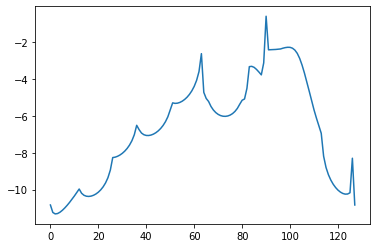

In [388]:
with torch.no_grad():
    import matplotlib.pyplot as plt
    plt.plot(flow_dist.log_prob(x).squeeze().numpy())

In [383]:
x.shape

torch.Size([128, 2])